# Analysis of VAM data

Look at data provided to SPI-M from PHE - the old VoC list and CoG don't seem to be quite right

Note that there is a paper on how to calculate better PIs for such GP priors at:

https://direct.mit.edu/neco/article/14/3/641/6594/Sparse-On-Line-Gaussian-Processes

http://www.cs.ubbcluj.ro/~csatol/SOGP/thesis/Gaussian_Process.html


In [97]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op
from numpy import linalg as LA
import sklearn.gaussian_process.kernels as sklk
from tqdm import tqdm

In [2]:
df = pd.read_csv('/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-05-17/20210516 VAM line list.csv')

/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df

,finalid,variant,variant_alt_name,seq_result,mutation,vam,exposure_type,specimen_date_sk,age,sex,...,imd_decile,death_type28,date_of_death,reporting_lab,pillar,pheccode,phecname,ltlacode,ltlaname,category
0,-1588825.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-08,4,F,...,3.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000018,North West,E08000001,Bolton,VOC
1,-3239610.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-07,44,F,...,1.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000018,North West,E08000001,Bolton,VOC
2,-3298539.0,VUI-21APR-01,Lineage B.1.617.1 (India),Confirmed,NaN,VUI-21APR-01,Awaiting information,2021-05-07,35,M,...,4.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000001,London,E09000011,Greenwich,VUI
3,-3306813.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-07,31,M,...,2.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000001,London,E09000007,Camden,VOC
4,-3307648.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-03,40,F,...,6.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000005,West Midlands,E06000019,"Herefordshire, County of",VOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216225,1672313.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-04-12,27,M,...,7.0,NaN,NaN,NATIONWIDE PATHOLOGY LIMITED,Pillar 1,E45000001,London,E09000009,Ealing,VOC
216226,1674217.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-04-18,NaN,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOC
216227,1676433.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-04-29,NaN,U,...,NaN,NaN,NaN,PHE NORTH WEST MANCHESTER LABORATORY,Pillar 1,NaN,NaN,NaN,NaN,VOC
216228,1677519.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-05-03,6,F,...,4.0,NaN,NaN,ONCOLOGICA UK,Pillar 1,E45000001,London,E09000030,Tower Hamlets,VOC


In [4]:
df.columns

Index(['finalid', 'variant', 'variant_alt_name', 'seq_result', 'mutation',
       'vam', 'exposure_type', 'specimen_date_sk', 'age', 'sex',
       'ethnicity_final', 'imd_decile', 'death_type28', 'date_of_death',
       'reporting_lab', 'pillar', 'pheccode', 'phecname', 'ltlacode',
       'ltlaname', 'category'],
      dtype='object')

In [5]:
pd.unique(df.variant_alt_name)

array(['Lineage B.1.617.2 (India)', 'Lineage B.1.617.1 (India)',
       'E484K (non-VOC/non-VUI)', 'Lineage B.1.1.318', 'Lineage B.1.525',
       'Lineage P1 (Japan ex Brazil)', 'Lineage B.1.351 (South Africa)',
       'Lineage B.1.324.1 with E484K', 'Lineage P.2. (Brazil)',
       'Lineage B.1.617.3 (India)',
       'Lineage B.1.1.7 (first detected in Kent)',
       'Lineage B.1.1.7 with E484K (Bristol focus)',
       'Lineage A.23.1 with E484K (Liverpool focus)',
       'Lineage P3 (Philippines)'], dtype=object)

In [6]:
dfg = df.groupby('variant_alt_name')

In [9]:
def todays(x):
    return np.array((pd.to_datetime(x['specimen_date_sk'], format='%Y-%m-%d') - pd.Timestamp("2021-01-01")) // pd.Timedelta('1D'))

In [11]:
lint = dfg.apply(todays)
lint

variant_alt_name
E484K (non-VOC/non-VUI)                        [121, 124, 125, 125, 127, 127, 127, 76, -24, -...
Lineage A.23.1 with E484K (Liverpool focus)    [-5.0, 9.0, 22.0, 22.0, 8.0, 3.0, 8.0, 8.0, 10...
Lineage B.1.1.318                              [124, 124, 127, 23, 24, 24, 30, 41, 49, 50, 50...
Lineage B.1.1.7 (first detected in Kent)       [-44, -45, 41, 50, -45, -45, -45, -44, -45, -4...
Lineage B.1.1.7 with E484K (Bristol focus)     [-14.0, -15.0, -2.0, 14.0, 2.0, 3.0, 3.0, 7.0,...
Lineage B.1.324.1 with E484K                                                              [7, 7]
Lineage B.1.351 (South Africa)                 [126.0, 127.0, 126.0, 40.0, 42.0, 58.0, 54.0, ...
Lineage B.1.525                                [126.0, 126.0, 125.0, 125.0, 14.0, 32.0, 44.0,...
Lineage B.1.617.1 (India)                      [126.0, 128.0, 122.0, nan, 110.0, 56.0, 56.0, ...
Lineage B.1.617.2 (India)                      [127.0, 126.0, 126.0, 122.0, 127.0, 126.0, 123...
Lineage B.1.6

In [52]:
lq = len(lint.index)
linnames = lint.index.values
tarr = lint.values

In [41]:
x = tarr[7]
z = x[~np.isnan(x)]
np.sort(z)

array([-17., -16.,  -4.,   3.,   3.,   3.,   3.,   8.,  10.,  11.,  12.,
        13.,  13.,  13.,  13.,  13.,  14.,  14.,  16.,  16.,  16.,  17.,
        18.,  18.,  18.,  19.,  19.,  20.,  21.,  21.,  21.,  22.,  22.,
        24.,  24.,  25.,  25.,  25.,  25.,  26.,  26.,  26.,  26.,  26.,
        26.,  27.,  27.,  28.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,
        31.,  31.,  31.,  31.,  31.,  31.,  31.,  32.,  33.,  33.,  33.,
        33.,  33.,  35.,  35.,  36.,  36.,  37.,  37.,  38.,  38.,  38.,
        38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  39.,  39.,
        39.,  39.,  40.,  40.,  40.,  41.,  41.,  41.,  43.,  43.,  44.,
        44.,  45.,  45.,  46.,  46.,  47.,  47.,  47.,  47.,  47.,  48.,
        48.,  49.,  49.,  49.,  49.,  50.,  50.,  50.,  51.,  51.,  51.,
        51.,  51.,  51.,  51.,  52.,  52.,  52.,  52.,  52.,  53.,  53.,
        53.,  53.,  53.,  53.,  53.,  54.,  54.,  54.,  54.,  54.,  54.,
        54.,  55.,  55.,  55.,  56.,  56.,  56.,  5

In [28]:
def mynll(x,tt,yy):
    
    lmu = x[0:n]
    lell = x[n]
    lsig = x[n+1]
    lod = x[n+2]
    
    od = np.exp(lod)*np.ones(n)
    p = 1/od
    r = np.exp(lmu)/(od-1)
    l1 = -np.sum(st.nbinom.logpmf(yy,r,p))
    
    kern = sklk.WhiteKernel(noise_level=1e-6) + (np.exp(lsig)**2)*sklk.RBF(length_scale=np.exp(lell))
    Kmat = kern(X=np.atleast_2d(tt).T)
    l2 = -st.multivariate_normal.logpdf(np.exp(lmu), mean=np.zeros(n), cov=Kmat, allow_singular=True)
    
    return l1 + l2

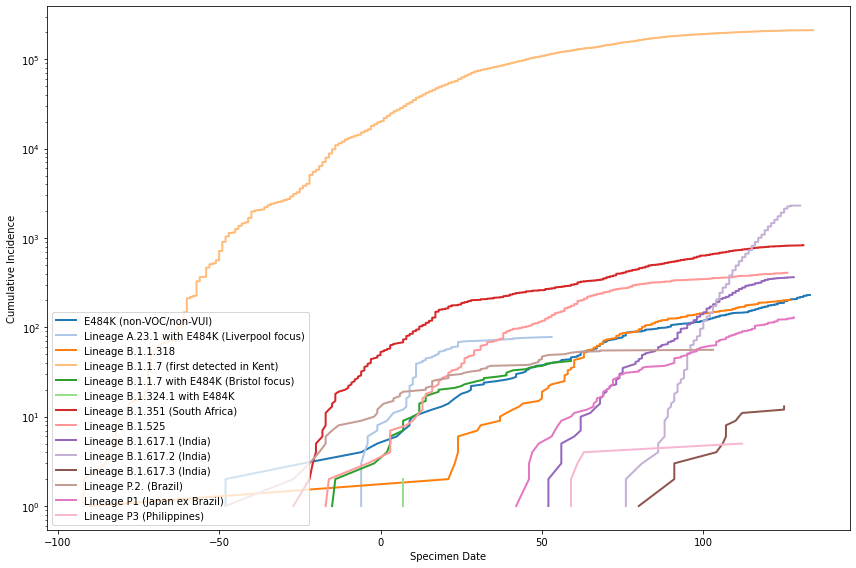

In [19]:

#cmp = plt.cm.get_cmap('Set3', lq+1)
cmp = plt.cm.get_cmap('tab20')
plt.figure(figsize=(12,8))
for i in range(0,lq):
    x = lint[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=lint.index[i], lw=2, c=cmp(i))
#for i, d in keydates.iterrows():
#    plt.plot(todays(d)*np.ones(2),np.array([0,500]),ls='--',label=d.date_name)
plt.legend()
plt.xlabel('Specimen Date')
plt.ylabel('Cumulative Incidence')
#plt.xticks(todays(monthstarts),tods(monthstarts))
#plt.xlim([0,212])
#plt.ylim([1,500])
plt.yscale('log')
#plt.title('England')
plt.tight_layout()
#plt.savefig('./figures/voc_region_log.pdf')

In [63]:
kk = ['Lineage B.1.617' in x for x in lint.index]

In [27]:
np.sum([len(x) for x in lint[kk]]) # There are only 211 in CoG microreact data

2697

In [42]:
k1 = ['Lineage B.1.617.1' in x for x in lint.index]
k2 = ['Lineage B.1.617.2' in x for x in lint.index]

In [68]:
t1 = tarr[k1][0]
t1 = t1[~np.isnan(t1)]
t2 = tarr[k2][0]
t2 = t2[~np.isnan(t2)]
uu = np.union1d(t1,t2)

In [111]:
tt = np.arange(np.min(t2),126)
n = len(tt)
y1 = np.zeros(n)
y2 = np.zeros(n)
for i, t in enumerate(tt):
    y1[i] = np.sum(t1==t)
    y2[i] = np.sum(t2==t)

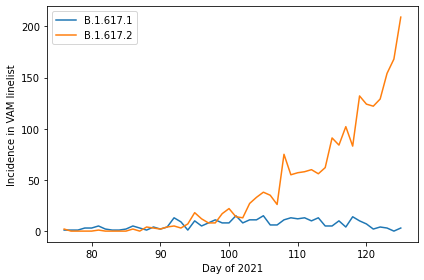

In [112]:
plt.figure(figsize=(6,4))
plt.xlabel('Day of 2021')
plt.ylabel('Incidence in VAM linelist')
plt.plot(tt,y1,label='B.1.617.1')
plt.plot(tt,y2,label='B.1.617.2')
plt.legend()
plt.tight_layout()
#plt.savefig('./figures/vam_b1617_inc.pdf')

<ipython-input-76-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-76-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1.0-p))


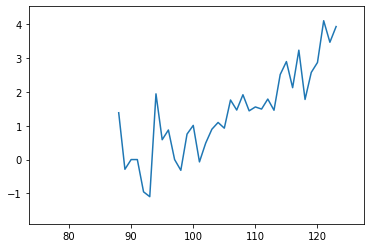

In [113]:
plt.plot(tt,logodds(y2/(y1+y2)))

In [114]:
def logodds(p):
    return np.log(p/(1.0-p))

def logistic(x):
    return (1.0/(1.0+np.exp(-x)))

In [115]:
lell = np.log(1.)
lsig = np.log(100.)
x0 = np.concatenate([np.zeros(n),[lell,lsig]]) # 2.*np.ones(n)
bb = np.concatenate([np.stack([-5*np.ones(n),5*np.ones(n)]).T,np.array([[-5,5],[-5,5]])])

In [116]:
def mynll(x,y1,y2):
    
    pp = logistic(x[0:n])
    lell = x[n]
    lsig = x[n+1]
    
    l1 = -np.sum(st.binom.logpmf(y2, y1+y2, pp, loc=0))
    
    kern = sklk.WhiteKernel(noise_level=1e-6) + (np.exp(lsig)**2)*sklk.RBF(length_scale=np.exp(lell))
    Kmat = kern(X=np.atleast_2d(tt).T)
    l2 = -st.multivariate_normal.logpdf(x[0:n], mean=np.zeros(n), cov=Kmat, allow_singular=True)
    
    return l1 + l2

In [117]:
mynll(x0,y1,y2)

1303.9232421067704

In [118]:
myf = lambda x : mynll(x,y1,y2)
fout = op.minimize(myf,x0,method='L-BFGS-B',bounds=bb,options={'maxfun':1000000})
fout

      fun: -141.82466831678954
 hess_inv: <52x52 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.70538766,  23.3374634 ,  10.84894729,   1.6347883 ,
        -3.56563985, -14.16732964, -20.05770331, -16.17479476,
        -9.04889243,  -4.75154136,   1.98400584,  11.49091412,
        21.40950245,  28.17008068,  20.19822319,   4.6092282 ,
        -2.96429335,  -1.41324108,  -0.7429378 ,  -6.61269724,
       -16.44717998, -21.46485373, -17.73698274,  -7.66122242,
         1.5737271 ,   2.01554257,   0.96787289,   4.5040508 ,
         6.01781661,   1.96932321,  -0.79677705,   7.14531443,
        19.22638842,  17.29840743,   9.9126965 ,   3.08888277,
        -8.23352485, -18.14856614, -18.45462532, -12.14118591,
        -1.06702487,   5.43290642,   2.5002919 ,   0.15602382,
         5.33724463,   8.27375293,   3.6345057 ,   2.95390239,
       -21.5690251 ,  12.34137422, -18.14906352,   4.91120321])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 70119
 

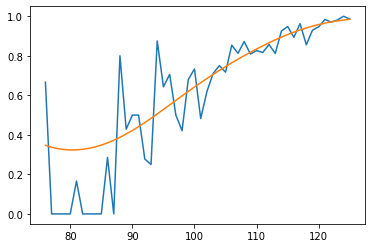

In [129]:
xhats = fout.x
phats = logistic(fout.x[0:n])
plt.plot(tt,y2/(y1+y2))
plt.plot(tt,phats)

<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1.0-p))


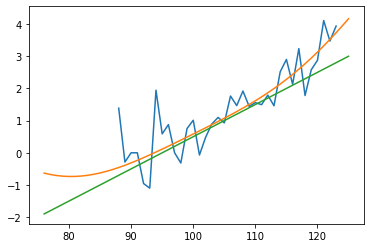

In [127]:
plt.plot(tt,logodds(y2/(y1+y2)))
plt.plot(tt,logodds(phats))
plt.plot(tt,0.1*(tt-95))

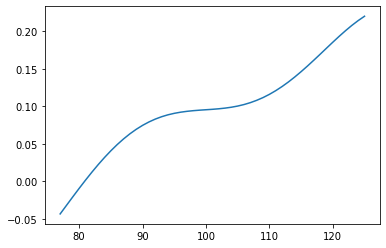

In [121]:
plt.plot(tt[1:],np.diff(logodds(phats)))

(0.0, 21.0)

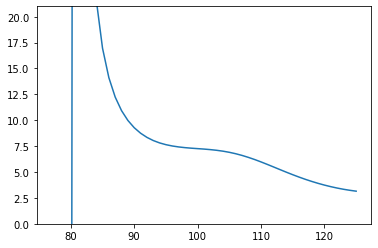

In [122]:
plt.plot(tt[1:],np.log(2)/np.diff(logodds(phats)))
plt.ylim([0,21])

In [128]:
np.log(2)/0.1

6.931471805599452

In [123]:
def myboot(x):
    return np.random.choice(x, size=x.shape, replace=True)

In [124]:
myboot(t2)

array([112., 113., 116., ..., 125., 116., 104.])

In [139]:
m = 100 # Number of bootstrap samples to take

In [151]:
pb = np.zeros((m,n))
y1b = np.zeros((m,n))
y2b = np.zeros((m,n))
for j in tqdm(range(0,m)):
    t1b = myboot(t1)
    t2b = myboot(t2)
    for i, t in enumerate(tt):
        y1b[j,i] = np.sum(t1b==t)
        y2b[j,i] = np.sum(t2b==t)
    myf = lambda x : mynll(x,y1b[j,:],y2b[j,:])
    foutb = op.minimize(myf,xhats,method='L-BFGS-B',bounds=bb,options={'maxfun':1000000})
    pb[j,:] = logistic(foutb.x[0:n])

100%|██████████| 100/100 [06:56<00:00,  4.17s/it]


<ipython-input-156-55272950c06b>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tt,logodds(y2b[j,:]/(y1b[j,:]+y2b[j,:])),c='k',alpha=0.1,lw=2)
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1.0-p))
<ipython-input-156-55272950c06b>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tt,logodds(y2b[j,:]/(y1b[j,:]+y2b[j,:])),c='k',alpha=0.1,lw=2)
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountere

<ipython-input-156-55272950c06b>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tt,logodds(y2b[j,:]/(y1b[j,:]+y2b[j,:])),c='k',alpha=0.1,lw=2)
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1.0-p))
<ipython-input-156-55272950c06b>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tt,logodds(y2b[j,:]/(y1b[j,:]+y2b[j,:])),c='k',alpha=0.1,lw=2)
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1.0-p))
<ipython-input-114-29d0f2932c9c>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1.0-p))
<ipython-input-156-55272950c06b>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tt,logodds(y2b[j,:]/(y1b[j,:]+y2b[j,:])),c='k',alpha=0.1,lw=2)
<ipython-input-114-29d0f2932c9c

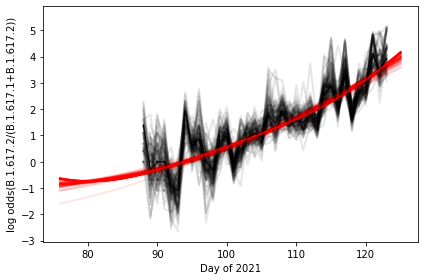

In [156]:
plt.figure(figsize=(6,4))
plt.xlabel('Day of 2021')
plt.ylabel('log odds(B.1.617.2/(B.1.617.1+B.1.617.2))')
for j in range(0,m):
    plt.plot(tt,logodds(y2b[j,:]/(y1b[j,:]+y2b[j,:])),c='k',alpha=0.1,lw=2)
    plt.plot(tt,logodds(pb[j,:]),c='r',alpha=0.1,lw=2)
plt.plot(tt,logodds(y2/(y1+y2)),c='k',lw=1)
plt.plot(tt,logodds(phats),c='r',lw=1)
plt.tight_layout()
plt.savefig('./figures/vam_b1617_lo.pdf')

In [ ]:
plt.figure(figsize=(6,4))
plt.xlabel('Day of 2021')
plt.ylabel('Relative doubling time of B.1.617.2')
for j in range(0,m):
    plt.plot(tt[1:],np.log(2)/np.diff(logodds(pb[j,:])),c='r',alpha=0.1,lw=2)
plt.plot(tt[1:],np.log(2)/np.diff(logodds(phats)),c='r',lw=1)
plt.tight_layout()
plt.ylim([0,21])

(0.0, 21.0)

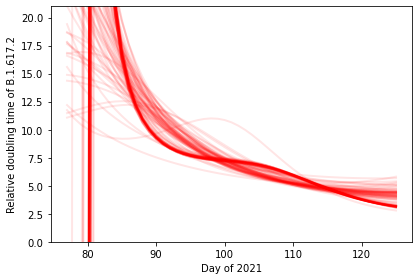

In [153]:
plt.figure(figsize=(6,4))
plt.xlabel('Day of 2021')
plt.ylabel('Relative doubling time of B.1.617.2')
for j in range(0,m):
    plt.plot(tt[1:],np.log(2)/np.diff(logodds(pb[j,:])),c='r',alpha=0.1,lw=2)
plt.plot(tt[1:],np.log(2)/np.diff(logodds(phats)),c='r',lw=1)
plt.tight_layout()
plt.ylim([0,21])